# Imports

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import mapclassify as mpc
import contextily as ctx

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report

# Data Import

In [65]:
#Get the data
airbnb = pd.read_csv("AB_NYC_2019.csv")
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [66]:
print('Number of features: {}'.format(airbnb.shape[1]))
print('Number of examples: {}'.format(airbnb.shape[0]))

Number of features: 16
Number of examples: 48895


In [67]:
airbnb.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [68]:
# Fill string columns' na with unknown
airbnb['name'].fillna('unknown',inplace=True)
airbnb['host_name'].fillna('unknown',inplace=True)

# Fill numerical columns' na with the mean
airbnb['reviews_per_month'].fillna(airbnb['reviews_per_month'].mean(),inplace=True)
'''not filling last_review yet to use it for feature engineering'''

airbnb.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

<AxesSubplot:>

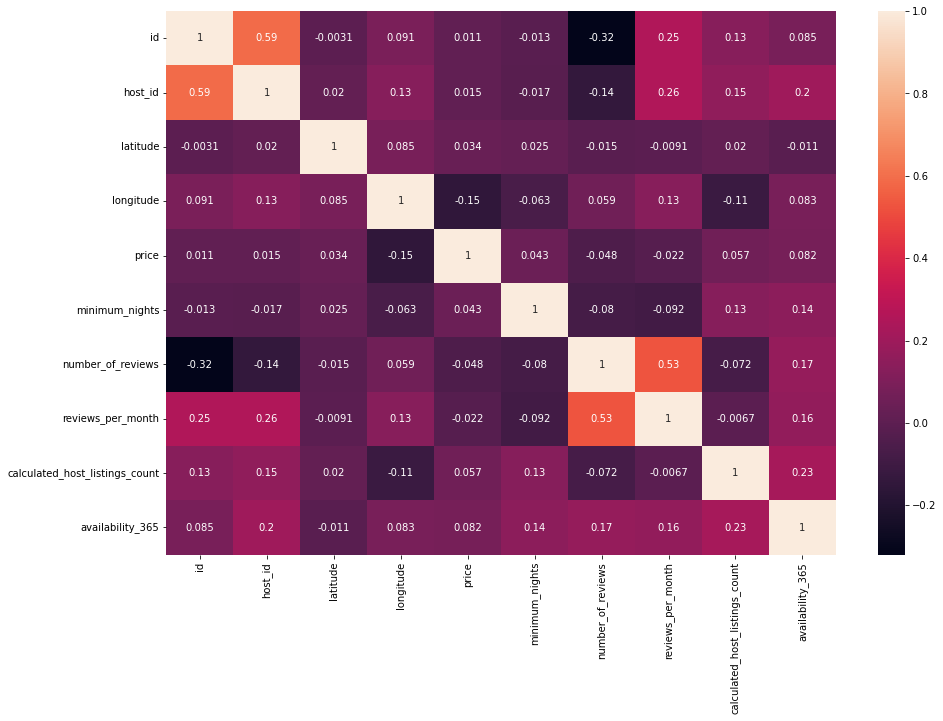

In [69]:
# Correlation man
corr = airbnb.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True)

# GEOSPATIAL ANALYSIS

In [71]:
geo_airbnb = gpd.GeoDataFrame(airbnb,  geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude))
geo_airbnb.crs = 'epsg:4326'
geo_airbnb = geo_airbnb
geo_airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365,POINT (-73.97237 40.64749)
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355,POINT (-73.98377 40.75362)
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1.373221,1,365,POINT (-73.94190 40.80902)
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.640000,1,194,POINT (-73.95976 40.68514)
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0,POINT (-73.94399 40.79851)


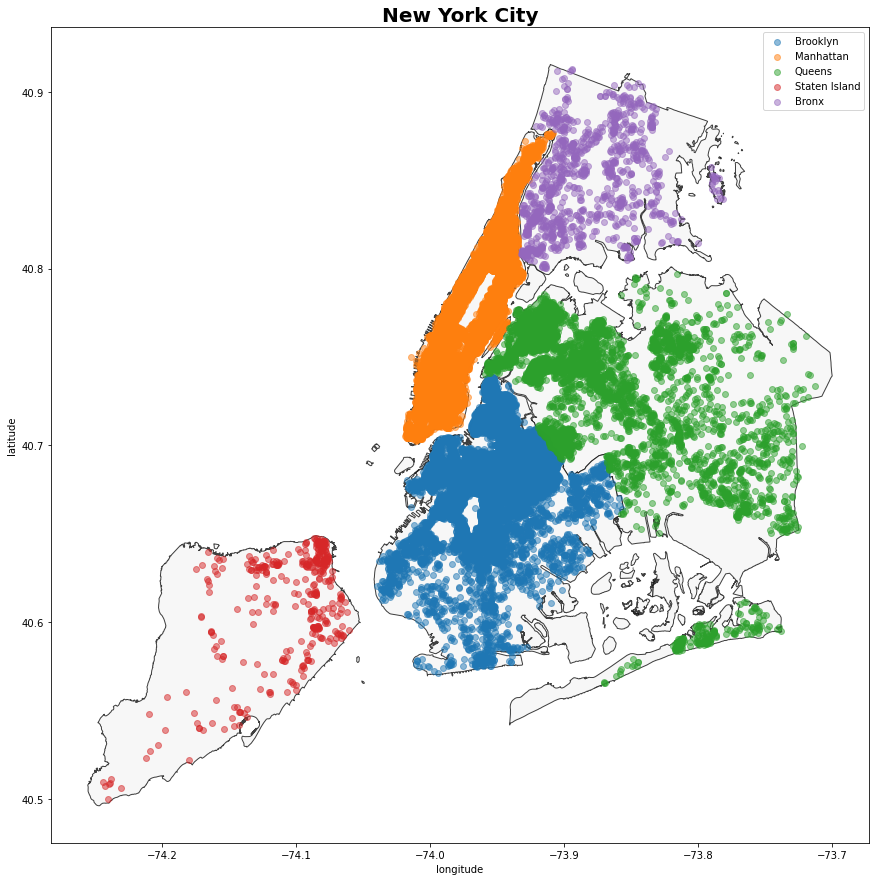

In [72]:
fact1 = pd.factorize(geo_airbnb['neighbourhood_group'])
fact2 = pd.factorize(geo_airbnb['room_type'])
geo_airbnb['neighbourhood_group'] = fact1[0]
geo_airbnb['room_type'] = fact2[0]
definitions1 = fact1[1]
definitions2 = fact2[1]

nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc = nyc.to_crs(epsg=4326)

ax = nyc.plot(figsize=(20,15), color='whitesmoke', edgecolor='black', alpha=0.75)
color=['#FF0000', '#0000FF', '#FFFF00', '#00FF00', '#DCDCDC']
region = list(definitions1)
for i in [0, 1, 2, 3, 4]:
    
    lon = geo_airbnb[geo_airbnb.neighbourhood_group == i].longitude
    lat = geo_airbnb[geo_airbnb.neighbourhood_group == i].latitude
    
    ax.scatter(lon, lat, cmap=color[i] , alpha=0.5, label = region[i])
    ax.set_title('New York City', fontsize=20, fontweight='bold')
    ax.set_xlabel('longitude', fontsize=10)
    ax.set_ylabel('latitude', fontsize=10)
    ax.legend(loc='best')

# Feature Engineering

In [73]:
#Creating that binary column (new listing : Yes/No)
airbnb["new_listing"] = 0
airbnb["new_listing"][airbnb["last_review"].isnull()] = 1

C:\Users\Davina Chen\AppData\Local\Temp\ipykernel_26032\2095246506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb["new_listing"][airbnb["last_review"].isnull()] = 1


In [74]:
#Now fill NA
airbnb['last_review'].fillna(0,inplace=True)

In [75]:
# What is the average price of new listings vs old ones
mean_price_new = airbnb.price[airbnb.new_listing==1].mean()
mean_price_old = airbnb.price[airbnb.new_listing==0].mean()
print('Mean price of old listings', mean_price_old)
print('Mean price of new listings', mean_price_new)

Mean price of old listings 142.317946605566
Mean price of new listings 192.9190210903303


In [76]:
# Cast the last_review column to datetime
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'])
airbnb.dtypes
# Create a column days since last review
airbnb['review_recency'] = (airbnb.last_review.max() - airbnb.last_review).dt.days

In [77]:
airbnb['all_year_avail'] = airbnb['availability_365']>350
airbnb['low_avail'] = airbnb['availability_365']< 12
#airbnb['no_reviews'] = airbnb['reviews_per_month']==0

airbnb['all_year_avail'] = airbnb['all_year_avail'].astype(object)
airbnb['low_avail'] = airbnb['low_avail'].astype(object)
#airbnb['no_reviews'] = airbnb['no_reviews'].astype(object)

In [78]:
# Encoding categorical variables
# label encoding for 'neighbourhood'
airbnb['neighbourhood'] = airbnb['neighbourhood'].astype("category").cat.codes

# one hot encoding for 'neighbourhood_group' and 'rooom_type'
ng_encoded = pd.get_dummies(airbnb['neighbourhood_group'])
rt_encoded = pd.get_dummies(airbnb['room_type'])
airbnb = pd.concat([airbnb,ng_encoded,rt_encoded],axis=1)

airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  int64         
 1   name                            48895 non-null  object        
 2   host_id                         48895 non-null  int64         
 3   host_name                       48895 non-null  object        
 4   neighbourhood_group             48895 non-null  int64         
 5   neighbourhood                   48895 non-null  int16         
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  int64         
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  int64         
 11  nu

In [79]:
# Getting rid of unimportant columns
airbnb.drop(columns=['id','name','host_id','host_name', 'neighbourhood_group','last_review','room_type'],inplace=True)
airbnb.head()

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,geometry,...,all_year_avail,low_avail,0,1,2,3,4,0,1,2
0,108,40.64749,-73.97237,149,1,9,0.210000,6,365,POINT (-73.97237 40.64749),...,True,False,1,0,0,0,0,1,0,0
1,127,40.75362,-73.98377,225,1,45,0.380000,2,355,POINT (-73.98377 40.75362),...,True,False,0,1,0,0,0,0,1,0
2,94,40.80902,-73.94190,150,3,0,1.373221,1,365,POINT (-73.94190 40.80902),...,True,False,0,1,0,0,0,1,0,0
3,41,40.68514,-73.95976,89,1,270,4.640000,1,194,POINT (-73.95976 40.68514),...,False,False,1,0,0,0,0,0,1,0
4,61,40.79851,-73.94399,80,10,9,0.100000,1,0,POINT (-73.94399 40.79851),...,False,True,0,1,0,0,0,0,1,0


In [80]:
X = airbnb.drop(['price','geometry'], axis=1)

#We will transform to logarithm and predict that
y = np.log(airbnb['price']+1)

In [81]:
#Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

c:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [82]:
#Perform a split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42)
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39116, 20)
Dimensions of the training target vector: (39116,)
Dimensions of the test feature matrix: (9779, 20)
Dimensions of the test target vector: (9779,)


# GradientBoosting

In [ ]:
# Tuning hyperparameters for Gradient Boosting Regressor model

GBoost = GradientBoostingRegressor()

# define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.1, 0.01, 0.05],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.3, 0.6, 0.9]
}

# perform grid search with 5-fold cross validation
grid_search = GridSearchCV(GBoost, param_grid, cv=5, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

# print the best parameters found by grid search
print(grid_search.best_params_)
print('Best score:', grid_search.best_score_)

# use the best estimator to make predictions on test set
y_pred = grid_search.predict(X_test)

# evaluate the model using r2 score
print('R2 score:', r2_score(y_test, y_pred))
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred)) #Transform back to original price
rmse = np.sqrt(mse)
print("RMSE:", rmse)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END learning_rate=0.1, max_depth=2, max_features=0.3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=0.3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=0.3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=0.3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=0.3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=2, max_features=0.3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=2, max_features=0.3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; t

In [84]:
GBoost = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, max_features=0.3, min_samples_leaf=4, min_samples_split=6)
GBoost.fit(X_train,y_train)

y_pred=GBoost.predict(X_test)

print("R2 score: ",r2_score(y_test,y_pred)*100)
print("R2 score for original price: ",r2_score(np.exp(y_test)-1, np.exp(y_pred)-1)*100)
print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("RMSE for original price: ",np.sqrt(mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)))

R2 score:  62.67636464847981
R2 score for original price:  20.46254980201664
RMSE:  0.4202065205129051
RMSE for original price:  187.57922712557948


# AdaBoost

In [87]:
# Tuning hyperparameters for AdaBoost Regressor model

AdaBoost = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=2))

# define the hyperparameters to tune
param_grid = {
		'base_estimator__max_depth':[2,4,6],
        'n_estimators': [50, 100, 200], 
        'learning_rate' : [0.01, 0.1, 0.5, 1]
        }

# perform grid search with 5-fold cross validation
grid_search = GridSearchCV(AdaBoost, param_grid, cv=5, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

# print the best parameters found by grid search
print(grid_search.best_params_)
print('Best score:', grid_search.best_score_)

# use the best estimator to make predictions on test set
y_pred = grid_search.predict(X_test)

# evaluate the model using r2 score
print('R2 score:', r2_score(y_test, y_pred))
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred)) #Transform back to original price
rmse = np.sqrt(mse)
print("RMSE:", rmse)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=50; total time=   1.6s
[CV] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=50; total time=   1.5s
[CV] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=50; total time=   1.5s
[CV] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=50; total time=   1.5s
[CV] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=50; total time=   1.5s
[CV] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=100; total time=   3.0s
[CV] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END base_estimator__max_depth=2, learning_rate=0.01, n_estimators=100; total time= 

In [85]:
AdaBoost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=12), n_estimators=100, learning_rate=0.01, random_state=1234)
AdaBoost.fit(X_train,y_train)

y_pred=AdaBoost.predict(X_test)

print("R2 score: ",r2_score(y_test,y_pred)*100)
print("R2 score for original price: ",r2_score(np.exp(y_test)-1, np.exp(y_pred)-1)*100)
print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("RMSE for original price: ",np.sqrt(mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1)))

R2 score:  61.25523469767157
R2 score for original price:  27.69326098433378
RMSE:  0.4281316509780359
RMSE for original price:  178.84973366865225
